Created on Sat Aug 21 04:43:30 2021

@author: Shannan

# Purpose

The goal of this analysis is primarily to learn more about how to compute and visualise the signals provided by technical indicators. A secondary aim is to make money in the stock market!

Technical Indicators used: **RSI, Bollinger Bands, SMA**

# Program

In [141]:
import pandas as pd
import numpy as np

# will help with grabbing data from yahoo finance API
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import style
import os
import datetime as dt
import sklearn
import bs4
from bs4 import BeautifulSoup

# Configuring chart settings
matplotlib.rcParams['figure.dpi'] = 200
style.use('ggplot')

In [1]:
# =============================================================================
# Sourcing the relevant data from Yahoo Finance
# =============================================================================

start = dt.datetime(2020,12,1) # Invested around here
end = dt.datetime(2021,8,24) # Most recent Date

# df = web.DataReader('0327.HK','yahoo',start,end)
df.to_csv('pax global_info.csv') # convert the dataframe into a csv

df = pd.read_csv('pax global_2020_Q3.csv',parse_dates=True,index_col = 0)
df.head()
# df[['Adj Close','Open','High']].plot().line(x = df.index)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-10-05,4.88,4.46,4.70,4.52,3438246.0,4.408570
2020-10-06,4.77,4.52,4.52,4.70,2695000.0,4.584132
2020-10-07,4.69,4.58,4.63,4.66,2039000.0,4.545118
2020-10-08,5.17,4.70,4.70,5.14,9877071.0,5.013286
2020-10-09,5.15,4.80,5.14,4.97,3796528.0,4.847476


In [15]:
# =============================================================================
# Technical indicators
#
# Compute the following technical indicators
# (1) simple moving averages (SMAs)
# (2) RSI
# (3) BollingerBands
# =============================================================================

def calc_sma(df,col_name,periods=50):
    """
    Parameters
        df: dataframe containing relevant stock information
        col_name: column for which you want the SMA to be computed
        periods: the number of periods over which you want to compute the SMA

    Returns
        No return value
        Adds a new column to your dataframe with the Simple Moving Average for
        the relevant column
    """
    df[f'{col_name}_sma{periods}'] = df[col_name].rolling(window = periods,min_periods=periods).mean()

def calc_bollinger_bands(df,col_name,num_std,periods=20):
    """
    Parameters
        df: dataframe containing relevant stock information
        col_name: column for which you want the SMA to be computed
        num_std: number of standard deviations you want the bollinger bands to capture
        periods: the number of periods over which you want to compute the SMA

    Returns
        Adds 2 new columns for the upper and lower bollinger bands and 1 for the SMA
        you want to compute for the relevant column
    """
    calc_sma(df,col_name,periods)
    std = df['Adj Close'].rolling(window = periods,min_periods=periods).std()
    df[f'{col_name}_ubb_{periods}_{num_std}'] = df[f'{col_name}_sma{periods}'] + std * num_std
    df[f'{col_name}_lbb_{periods}_{num_std}'] = df[f'{col_name}_sma{periods}'] - std * num_std


def calc_rsi(df, col_name, ema = True,periods = 14):
    """
    Parameters
        df: dataframe containing relevant stock information
        col_name: column for which you want the RSI to be computed
        ema: if True, compute RSI using EMA; else use SMA
        periods: defaults to 14, but in general is the number of periods over which you want to compute

    Returns a pd.Series with the relative strength index
    """
    delta = df[col_name].diff()

    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)

    if ema == True:
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [115]:
# =============================================================================
# Strategy Implementation
# RSI
# Bollinger Bands (BB)
# SMA
# RSI/BB
# =============================================================================

# =============================================================================
# Implement a Relative Strength Index Strategy
#
# BUY: if the adj close price RSI crosses above the RSI lower bound
# SELL: if the RSI crosses below the RSI upper bound
# =============================================================================

def implement_rsi_strategy(col_name,rsi,lb_rsi,ub_rsi):
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(0, len(rsi)):

        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(col_name[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(col_name[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)

    return buy_price, sell_price, rsi_signal


# =============================================================================
# Implement a Bollinger Band Strategy
#
# BUY: if the adj close price crosses below the lower bollinger band 
# SELL: if the adj close price crosses above the upper bollinger band 
# =============================================================================

def implement_bb_strategy(col_name,lbb,ubb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0

    for i in range(0, len(col_name)):
        # buy signal
        if (rsi[i-1] < lb_rsi and rsi[i] > lb_rsi):
            if signal != 1:
                buy_price.append(col_name[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
                
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(np.nan)

        # sell signal
        elif (rsi[i-1] > ub_rsi and rsi[i] < ub_rsi):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(col_name[i])
                signal = -1
                rsi_signal.append(signal)
                
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(np.nan)

        # do nothing if not signal
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(np.nan)

    return buy_price, sell_price, bb_signal

def implement_sma_strategy(col_name,sma_ST,sma_LT):
    buy_price = []
    sell_price = []
    sma_signal = []
    signal = 0
    
    for i in range(0, len(sma_LT)):
        if (sma_ST[i-1] < sma_LT[i-1] and sma_ST[i] > sma_LT[i]):
            if signal != 1:
                buy_price.append(col_name[i])
                sell_price.append(np.nan)
                signal = 1
                sma_signal.append(signal)

            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(np.nan)
    
        # sell signal
        elif (sma_ST[i-1] > sma_LT[i-1] and sma_ST[i] < sma_LT[i]):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(col_name[i])
                signal = -1
                sma_signal.append(signal)
            
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                sma_signal.append(np.nan)

        # do nothing if not signal
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            sma_signal.append(np.nan)

    return buy_price, sell_price, bb_signal

# =============================================================================
# Implement a Compoound Strategy involving RSI and Bollinger Bands
#
# BUY: if the adj close price (1) crosses below the lower bollinger band AND
#   (2) RSI crosses above the RSI lower bound
# SELL: if the adj close price (1) crosses above the upper bollinger band AND
# (2) RSI crosses below the RSI upper bound
# =============================================================================
def implement_bb_rsi_strategy(col_name,lbb,ubb,rsi,lb_rsi,ub_rsi):
    buy_price = []
    sell_price = []
    bb_rsi_signal = []
    signal = 0

    for i in range(0, len(col_name)):

        # buy signal
        if (col_name[i-1] > lbb[i-1] and col_name[i] < lbb[i] and
            rsi[i-1] < lb_rsi and rsi[i] > lb_rsi):
            if signal != 1:
                buy_price.append(col_name[i])
                sell_price.append(np.nan)
                signal = 1
                bb_rsi_signal.append(signal)

            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_rsi_signal.append(np.nan)

        # sell signal
        elif (col_name[i-1] < ubb[i-1] and col_name[i] > ubb[i] and
              rsi[i-1] > ub_rsi and rsi[i] < ub_rsi):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(col_name[i])
                signal = -1
                bb_rsi_signal.append(signal)

            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_rsi_signal.append(np.nan)

        # do nothing if not signal
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_rsi_signal.append(np.nan)

    return buy_price, sell_price, bb_rsi_signal

# =============================================================================
# implement_bb_rsi_sma_strategy
#
# BUY: if the adj close price (1) crosses below the lower bollinger band AND
# (2) RSI crosses above the lower bound AND
# (3) SMA50 crosses above SMA200
#
# SELL: if the adj close price (1) crosses above the upper bollinger band AND
# (2) RSI crosses below the upper bound AND
# (3) SMA50 crosses below SMA200
#
# TRACK:
# (1) number of trades
# (2) number of buys and sells
# (3) average win from buy and sell
# =============================================================================


In [116]:
df = pd.read_csv('pax global_info.csv',parse_dates=['Date'],index_col = ['Date'])
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-01,6.59,5.13,5.20,6.53,45721000.0,6.369019
2020-12-02,6.71,6.02,6.35,6.26,19455104.0,6.105675
2020-12-03,6.30,5.95,6.22,6.12,6568600.0,5.969126
2020-12-04,6.20,5.84,6.20,6.03,6716556.0,5.881345
2020-12-07,6.34,5.80,6.12,6.22,6993500.0,6.066660


In [117]:
calc_sma(df,'Close',25)
calc_sma(df,'Close',50)
calc_sma(df,'Close',100)
calc_bollinger_bands(df,'Close',2,20)
df['rsi'] = calc_rsi(df,'Close',ema=True,periods=14)

In [63]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,Close_sma25,Close_sma50,Close_sma100,Close_sma20,Close_ubb_20_2,Close_lbb_20_2,rsi
Date,,,,,,,,,,,,,
2020-12-01,6.59,5.13,5.20,6.53,45721000.0,6.369019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-02,6.71,6.02,6.35,6.26,19455104.0,6.105675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-03,6.30,5.95,6.22,6.12,6568600.0,5.969126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-04,6.20,5.84,6.20,6.03,6716556.0,5.881345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-07,6.34,5.80,6.12,6.22,6993500.0,6.066660,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
buy_price_rsi, sell_price_rsi, rsi_signal = implement_rsi_strategy(df['Close'],df['rsi'], 30, 70)
buy_price_bb, sell_price_bb, bb_signal = implement_bb_strategy(df['Close'], df['Close_lbb_20_2'], df['Close_ubb_20_2'])
buy_price_sma, sell_price_sma, sma_signal = implement_sma_strategy(df['Close'],df['Close_sma25'],df['Close_sma50'])
buy_price_bb_rsi, sell_price_bb_rsi, bb_rsi_signal = implement_bb_rsi_strategy(df['Close'], df['Close_lbb_20_2'], df['Close_ubb_20_2'],df['rsi'], lb_rsi=30, ub_rsi=70)

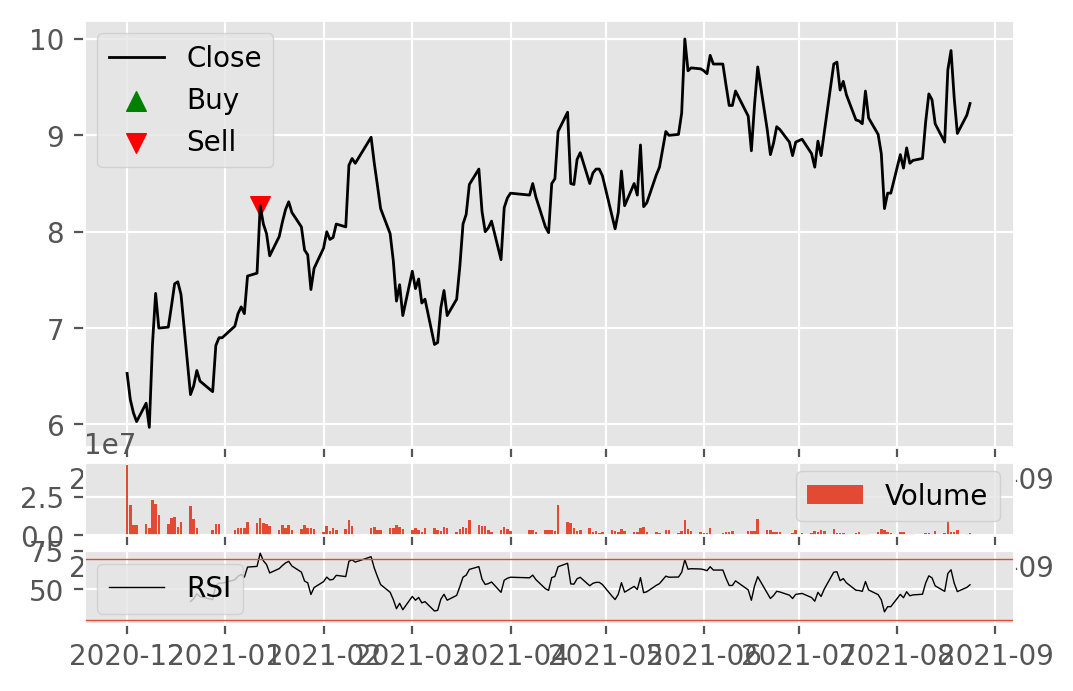

In [130]:
# =============================================================================
# graphing with matplotlib
# each matplotlib graphic frame can have multiple subplots
# subplots are referred to as axes (ax)
# =============================================================================

# =============================================================================
# create subplots
# subplot2grid creates an axis (subplot) in location inside a regular grid
# ax1 will span 5 rows and be located in column 1 of our grid space
# ax2 will span 1 row and be located in column 1 of our grid space
# =============================================================================

# =============================================================================
# plot the RSI buy and sell signals along with stock trading volume and the RSI graph
# =============================================================================
df['buy_price_rsi'] = buy_price_rsi
df['sell_price_rsi'] = sell_price_rsi

ax1 = plt.subplot2grid((7,1),(0,0),rowspan = 5,colspan = 1)
ax2 = plt.subplot2grid((7,1),(5,0),rowspan = 1,colspan = 1,sharex=ax1)
ax3 = plt.subplot2grid((7,1),(6,0),rowspan = 1,colspan = 1,sharex=ax1)

ax1.plot(df.index,df['Close'],color = 'black',linewidth=1)
ax1.legend(['Close','Buy','Sell'])

ax1.scatter(df.index[df['buy_price_rsi'].isnull()==False],
            y = df['buy_price_rsi'][df['buy_price_rsi'].isnull()==False], 
            marker = '^', color = 'green', label = 'BUY', s = 50)
ax1.scatter(df.index[df['sell_price_rsi'].isnull()==False],
            y = df['sell_price_rsi'][df['sell_price_rsi'].isnull()==False], 
            marker = 'v', color = 'red', label = 'SELL', s = 50)
ax1.legend(['Close','Buy','Sell'])

ax2.bar(df.index,df['Volume'])
ax2.legend(['Volume'])

ax3.plot(df.index,df['rsi'],color='black',linewidth=0.5)
ax3.axhline(y=70,linewidth=0.5)
ax3.axhline(y=30,linewidth=0.5)
ax3.legend(['RSI'])

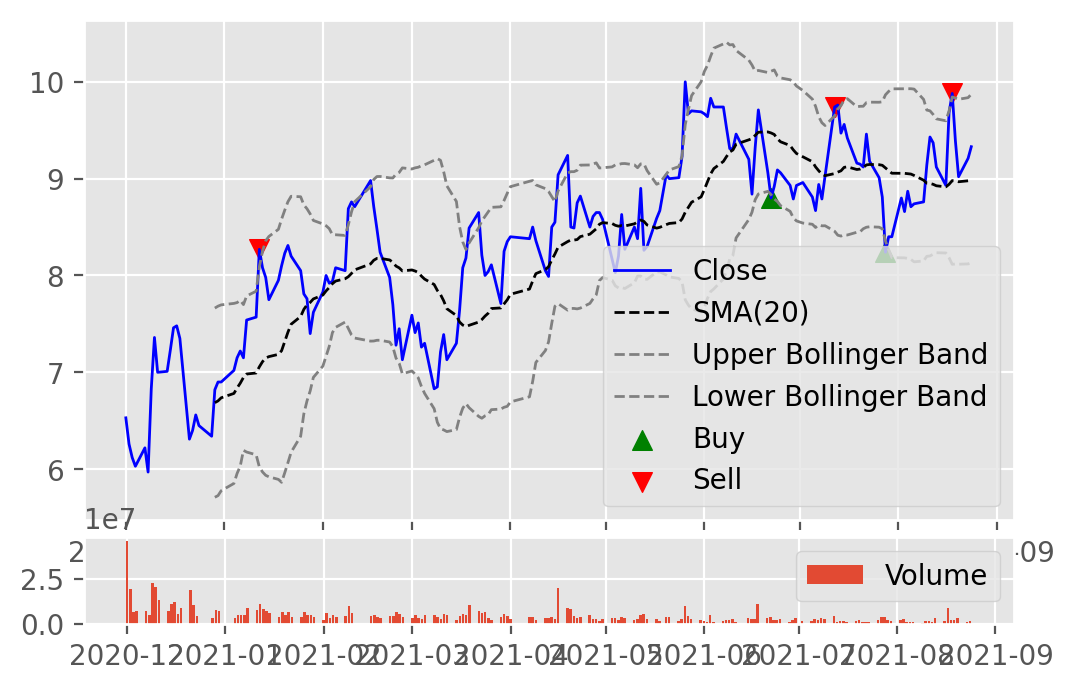

In [135]:
# =============================================================================
# plot the Bollinger Band buy and sell signals along with stock trading volume
# =============================================================================
df['buy_price_bb'] = buy_price_bb
df['sell_price_bb'] = sell_price_bb

ax1 = plt.subplot2grid((6,1),(0,0),rowspan = 5,colspan = 1)
ax2 = plt.subplot2grid((6,1),(5,0),rowspan = 1,colspan = 1)
# plot stuff on the subplots
ax1.plot(df.index,df['Close'],color = 'blue',linewidth=1)
ax1.plot(df.index,df['Close_sma20'],linestyle='--', linewidth = 1,color = 'black')
ax1.plot(df.index,df[['Close_ubb_20_2','Close_lbb_20_2']],
         linestyle = '--',linewidth=1,color = 'grey')

ax1.scatter(df.index[df['buy_price_bb'].isnull()==False],
            y = df['buy_price_bb'][df['buy_price_bb'].isnull()==False], 
            marker = '^', color = 'green', label = 'BUY', s = 50)
ax1.scatter(df.index[df['sell_price_bb'].isnull()==False],
            y = df['sell_price_bb'][df['sell_price_bb'].isnull()==False], 
            marker = 'v', color = 'red', label = 'SELL', s = 50)

ax1.legend(['Close','SMA(20)','Upper Bollinger Band','Lower Bollinger Band','Buy','Sell'])
ax2.bar(df.index,df['Volume'])
ax2.legend(['Volume'])

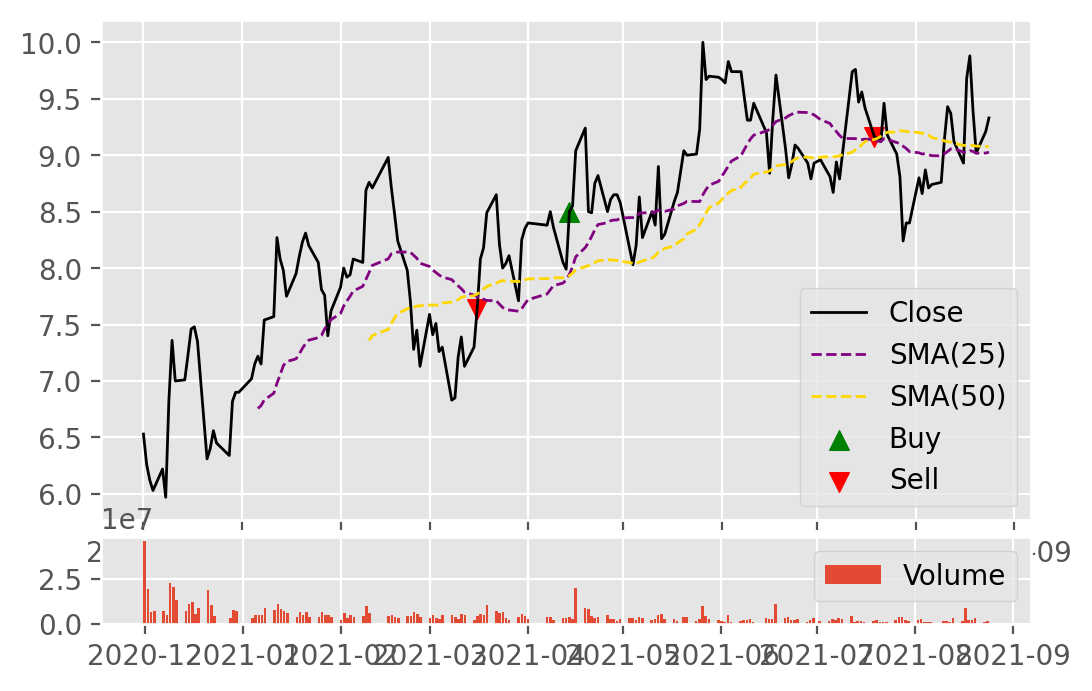

In [139]:
# =============================================================================
# plot the SMA 25, 100 buy and sell signals along with stock trading volume
# =============================================================================
df['buy_price_bb_rsi'] = buy_price_sma
df['sell_price_bb_rsi'] = sell_price_sma

ax1 = plt.subplot2grid((6,1),(0,0),rowspan = 5,colspan = 1)
ax2 = plt.subplot2grid((6,1),(5,0),rowspan = 1,colspan = 1)

ax1.plot(df.index,df['Close'],color = 'black',linewidth=1)
ax1.plot(df.index,df['Close_sma25'],linestyle='--', linewidth = 1,color = 'purple')
ax1.plot(df.index,df['Close_sma50'],linestyle='--', linewidth = 1,color = 'gold')
ax1.scatter(df.index[df['buy_price_bb_rsi'].isnull()==False],
            y = df['buy_price_bb_rsi'][df['buy_price_bb_rsi'].isnull()==False], 
            marker = '^', color = 'green', label = 'BUY', s = 50)
ax1.scatter(df.index[df['sell_price_bb_rsi'].isnull()==False],
            y = df['sell_price_bb_rsi'][df['sell_price_bb_rsi'].isnull()==False], 
            marker = 'v', color = 'red', label = 'SELL', s = 50)

ax1.legend(['Close','SMA(25)','SMA(50)','Buy','Sell'])
ax2.bar(df.index,df['Volume'])
ax2.legend(['Volume'])

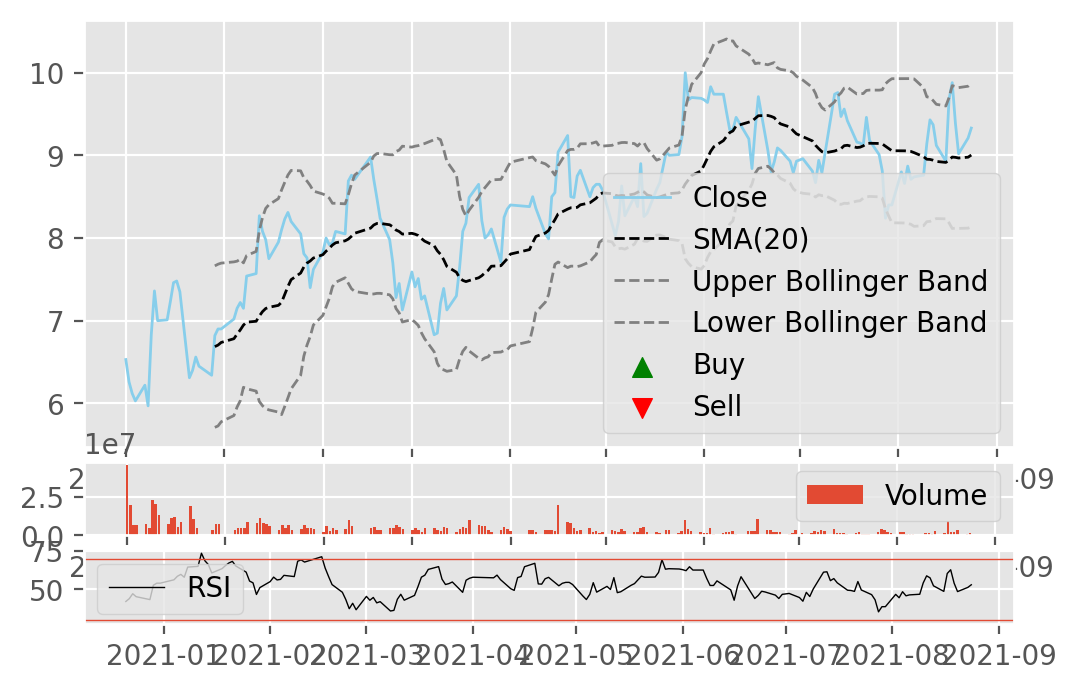

In [140]:
# =============================================================================
# plot the Bollinger Band & RSI buy and sell signals along with stock trading volume
# =============================================================================
ax1 = plt.subplot2grid((7,1),(0,0),rowspan = 5,colspan = 1)
ax2 = plt.subplot2grid((7,1),(5,0),rowspan = 1,colspan = 1)
ax3 = plt.subplot2grid((7,1),(6,0),rowspan = 1,colspan = 1)

df['buy_price_bb_rsi'] = buy_price_bb_rsi
df['sell_price_bb_rsi'] = sell_price_bb_rsi

# plot stuff on the subplots
ax1.plot(df.index,df['Close'],color = 'skyblue',linewidth=1)
ax1.plot(df.index,df['Close_sma20'],linestyle='--', linewidth = 1,color = 'black')
ax1.plot(df.index,df[['Close_ubb_20_2','Close_lbb_20_2']],
         linestyle = '--',linewidth=1,color = 'grey')


ax1.scatter(df.index[df['buy_price_bb_rsi'].isnull()==False],
            y = df['buy_price_bb_rsi'][df['buy_price_bb_rsi'].isnull()==False], 
            marker = '^', color = 'green', label = 'BUY', s = 50)
ax1.scatter(df.index[df['sell_price_bb_rsi'].isnull()==False],
            y = df['sell_price_bb_rsi'][df['sell_price_bb_rsi'].isnull()==False], 
            marker = 'v', color = 'red', label = 'SELL', s = 50)

ax1.legend(['Close','SMA(20)','Upper Bollinger Band',
            'Lower Bollinger Band','Buy','Sell'])
ax2.bar(df.index,df['Volume'])
ax2.legend(['Volume'])

ax3.plot(df.index,df['rsi'],color='black',linewidth=0.5)
ax3.axhline(y=70,linewidth=0.5)
ax3.axhline(y=30,linewidth=0.5)
ax3.legend(['RSI'])


## Commentary on Results & Further Study

In the short time frame we map our data over, it appears that the BB strategy is most active while the compound strategy and RSI strategy essentially are inactive. 

This tells us that RSI is not a strong indicator for this stock. 

Overall, this was an interesting and personally informative study of some technical indicators in Python, and I may revisit technical analysis with another stock in the future using this template. For Pax Global Technology, there is no buy signal indicated by any of these charts, so no stock purchasing will be taking place (for now!)

We'll continue this Finance in Python series by examining the S&P500 index, which I'm also invested in. 